## Python program to find solution of the 2D Poisson's equation
## with periodic boundary conditions

In [2]:
from __future__ import division
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import ifftn
from scipy.fftpack import fft, fft2, fftn, ifft2, rfft, dct, dst

## Fourier coefficients

$\laplace \phi=\rho$

The discrete form of the equation is written in the following way

$\frac{1}{h^2}[\phi_{j+1,k}+\phi_{j-1,k}+\phi_{j,k+1}+\phi_{j,k-1}-4\phi_{j,k}]=-\rho_{j,k}$

The Fourier transform of the two functiona are

$\tilde{\phi}_{m,n}=\frac{1}{N} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} W^{mj+nk} \phi_{j,k} $

$\tilde{\rho}_{m,n}=\frac{1}{N} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} W^{mj+nk} \rho_{j,k} $

The inverse transforms are 


$\phi_{j,k}=\frac{1}{N} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} W^{-mj-nk} \tilde{\phi}_{m,n} $

$\rho_{j,k}=\frac{1}{N} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} W^{-mj-nk} \tilde{\rho}_{m,n} $

Plugging these expressions into the discretized equation and equating coefficients
of $W^{-mj-nk}$ gives

$\frac{1}{h^2}[W^m + W^{-m}+W^{n}+W^{-n}-4]\tilde{\phi}_{m,n}=\tilde{\rho}_{m,n}$

which is easily solved for

$\tilde{\phi}_{m,n}=\frac{h^2 \tilde{\rho}_{m,n}}{4-W^m - W^{-m}-W^{n}-W^{-n}}$

Then, backtranforming one obtains the solution $\phi_{j,k}$


In [3]:
#W=Exp[2pi i  /N]
#W^m=Cos[2 pi m/M] + i Sin [2 pi m/M]

class fourier_coeff():

    def __init__(self, m, N):

        self.cosine=np.cos(2* np.pi * m /N )
        self.sine=np.sin (2* np.pi * m /N )
        
        self.complex_value=self.cosine + self.sine*1j




##  Routine for creating a 2D gaussian


In [4]:
def gaussian(x0,y0, low_bound, high_bound, sigma, N):

    x, y = np.linspace(low_bound, high_bound,npx), np.linspace(low_bound, high_bound,npx)

    xy, yy=np.meshgrid(x, y)

    gx = np.exp(-(x-x0)**2/(2*sigma**2))
    gy = np.exp(-(y-y0)**2/(2*sigma**2))

    gauss = np.outer(gy, gx)
    gauss /= np.sum(gauss)  # normalize, if you want that

    gauss_new=np.zeros([N,N])

    max_val=-1

    for ii in range(len(x)):

        for jj in range(len(y)):

            gauss_new[ii][jj]=np.exp(-(x[ii]-x0)**2/(2*sigma**2))* np.exp(-(y[jj]-y0)**2/(2*4*sigma**2))

            if (gauss_new[ii][jj] > max_val):
                
                ii_max=ii
                jj_max=jj
                max_val=gauss_new[ii][jj]

    print('Center', x0,y0)            
    print('Maximum at', x[ii_max], y[jj_max])        
    return(gauss_new)



### Potential terms

In [5]:
########################################################################
def potential_terms(fft_source, h):

    npx=fft_source.shape[0]

    phi_fft=np.zeros((npx, npx), dtype=complex)

    for m in range (npx):
        for n in range (npx):

            Wm=fourier_coeff(m, npx)
            Wn=fourier_coeff(n, npx)
            
            denom=(4-Wm.complex_value -1 /Wm.complex_value- Wn.complex_value - 1/Wn.complex_value)

            if abs(denom) !=0:
                phi_fft[n][m]=h*h* fft_source[n][m]/denom


    return(phi_fft)


#####################################################################################


### Define the number of pixel of the box and the boundary limits of the coordinates

In [6]:
npx=128
xmin, xmax=0, 40
ymin, ymax=0, 40

xe =np.linspace(xmin,xmax,npx) 
ye =np.linspace(ymin, ymax, npx)
x, y = np.meshgrid(xe,ye)

step=(xmax-xmin)/npx


### Here define the surface density: as an example we can use some 2D gaussians

In [7]:
#x0=round((npx+1)/2)*step
#y0=round((npx+1)/2)*step

x0,y0=20,20

sigma=1

gauss1=gaussian(x0,y0, xmin,xmax, sigma, npx)
gauss2=gaussian(x0+5,y0+5, xmin,xmax, sigma, npx)
gauss3=gaussian(x0+1,y0+1, xmin,xmax, sigma/2, npx)

gauss=gauss1+gauss2+0*gauss3

Center 20 20
Maximum at 19.84251968503937 19.84251968503937
Center 25 25
Maximum at 24.881889763779526 24.881889763779526
Center 21 21
Maximum at 21.102362204724407 21.102362204724407


### Perform the FFT with implicit periodic boundary conditions

In [8]:
fft_gauss=fft2(gauss)

res=potential_terms(fft_gauss, step)

U=ifft2(res)

#multiple_img=replicate_image(U)



Dimensions (128, 128)
Dimensions (128, 128)


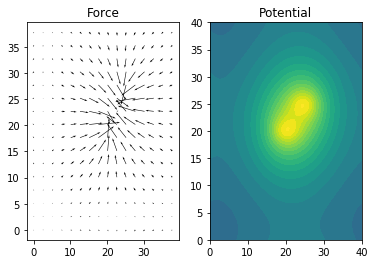

In [9]:
#######################################################################
#2D gradient of the potential

X,Y=np.meshgrid(xe,ye)
grad_U=np.gradient(U.real,xe,ye)


####################################################################################
#Arrows field which represent the gravitational (or electrical force)

skip = (slice(None, None, 8), slice(None, None, 8))
#Q = plt.quiver(Y[skip], X[skip], grad_U[0][skip], grad_U[1][skip], units='width')

####################################################################################
#First panel, plot of data and best-fit model

extent = xmin, xmax,ymin, ymax

ax1 = plt.subplot2grid((1,2), (0, 0))
plt.title('Force')
#plt.imshow(gauss, extent=extent)
#plt.contourf(xe, ye, gauss)
Q = plt.quiver(Y[skip], X[skip], grad_U[0][skip], grad_U[1][skip], units='width')

ax2 = plt.subplot2grid((1, 2), (0, 1))
plt.title('Potential')
plt.contourf(xe, ye, U.real, 15, norm=plt.Normalize(vmax=abs(U).max(), vmin=-abs(U).max()))


print('Dimensions', grad_U[0].shape)
print('Dimensions', grad_U[1].shape)

plt.savefig('potential.pdf')
plt.show()
#os.sys.exit(1)

######################################################################
#Call the function which takes as input the source term N x N
#matrix and returns a totally simmetrix 2N * 2N matrix

#block_image=matrix_mirror(gauss)

########################################################################

#ax2.imshow(np.abs(np.fft.fftshift(fft_z)))


